## Packages
Install and import all the required packages and modules.


In [ ]:
## upgrading pip
!pip install -q --upgrade pip

## installing the latest transformers version from pip
!pip install --use-feature=2020-resolver -q transformers==3.0.2
import transformers

## installing Google Translator package
#!pip install -q googletrans
#!pip install googletrans==3.1.0a0

In [ ]:
## importing packages
import gc
import os
import random
import transformers
import warnings

import calendar
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report

from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel

print(f"TensorFlow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")

warnings.filterwarnings("ignore")


## Configuration
This is the most important section of the notebook. The configuration class is setup to define as many levers required for experiments as possible. It is currently meant to experiment on the following:

* Different Huggingface models with Tensorflow 
* Different hyper-parameter spaces for models 
* Different seeds, splits, accelerators 


In [ ]:
## defining configuration
class Configuration():
    """
    All configuration for running an experiment
    """
    def __init__(
        self,
        model_name,
        translation = True,
        max_length = 64,
        padding = True,
        batch_size = 128,
        epochs = 5,
        learning_rate = 1e-5,
        metrics = ["sparse_categorical_accuracy"],
        verbose = 1,
        train_splits = 5,
        accelerator = "TPU",
        myluckynumber = 13
    ):
        # seed and accelerator
        self.SEED = myluckynumber
        self.ACCELERATOR = accelerator

        # Translated dataset
        self.PATH_TRAIN = Path("/kaggle/input/translated-nli-dataset/train_en.csv")
        self.PATH_TEST  = Path("/kaggle/input/translated-nli-dataset/test_en.csv")

        # splits
        self.TRAIN_SPLITS = train_splits

        # mapping of language
        self.LANGUAGE_MAP = {
            "English"   : 0,
            "Chinese"   : 1,
            "Arabic"    : 2,
            "French"    : 3,
            "Swahili"   : 4,
            "Urdu"      : 5,
            "Vietnamese": 6,
            "Russian"   : 7,
            "Hindi"     : 8,
            "Greek"     : 9,
            "Thai"      : 10,
            "Spanish"   : 11,
            "German"    : 12,
            "Turkish"   : 13,
            "Bulgarian" : 14
        }

        self.INVERSE_LANGUAGE_MAP = {v: k for k, v in self.LANGUAGE_MAP.items()}

        # model configuration
        self.MODEL_NAME = model_name
        self.TRANSLATION = translation
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_NAME)

        # model hyperparameters
        self.MAX_LENGTH = max_length
        self.PAD_TO_MAX_LENGTH = padding
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.LEARNING_RATE = learning_rate
        self.METRICS = metrics
        self.VERBOSE = verbose
        
        # initializing accelerator
        self.initialize_accelerator()

    def initialize_accelerator(self):
        """
        Initializing accelerator
        """
        # checking TPU first
        if self.ACCELERATOR == "TPU":
            print("Connecting to TPU")
            try:
                tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
                print(f"Running on TPU {tpu.master()}")
            except ValueError:
                print("Could not connect to TPU")
                tpu = None

            if tpu:
                try:
                    print("Initializing TPU")
                    tf.config.experimental_connect_to_cluster(tpu)
                    tf.tpu.experimental.initialize_tpu_system(tpu)
                    self.strategy = tf.distribute.experimental.TPUStrategy(tpu)
                    self.tpu = tpu
                    print("TPU initialized")
                except _:
                    print("Failed to initialize TPU")
            else:
                print("Unable to initialize TPU")
                self.ACCELERATOR = "GPU"

        # default for CPU and GPU
        if self.ACCELERATOR != "TPU":
            print("Using default strategy for CPU and single GPU")
            self.strategy = tf.distribute.get_strategy()

        # checking GPUs
        if self.ACCELERATOR == "GPU":
            print(f"GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

        # defining replicas
        self.AUTO = tf.data.experimental.AUTOTUNE
        self.REPLICAS = self.strategy.num_replicas_in_sync
        print(f"REPLICAS: {self.REPLICAS}")


# Data preparation:

In [ ]:
## data preparation functions
def translate_text_to_english(text):
    """
    Translates text to English.
    """
    translator = Translator()

    return translator.translate(text, dest = "en").text


def encode_text(df, tokenizer, max_len, padding):
    """
    Preprocessing textual data into encoded tokens.
    """
    text = df[["premise", "hypothesis"]].values.tolist()

    # encoding text using tokenizer of the model
    text_encoded = tokenizer.batch_encode_plus(
        text,
        pad_to_max_length = padding,
        max_length = max_len
    )

    return text_encoded


def get_tf_dataset(X, y, auto, labelled = True, repeat = False, shuffle = False, batch_size = 128):
    """
    Creating tf.data.Dataset for TPU.
    """
    if labelled:
        ds = (tf.data.Dataset.from_tensor_slices((X["input_ids"], y)))
    else:
        ds = (tf.data.Dataset.from_tensor_slices(X["input_ids"]))

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(2048)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(auto)

    return ds


## Deep Learning model architecture
Defining the deep learning network architecture along with the model configuration

In [ ]:
## building model
def build_model(model_name, max_len, learning_rate, metrics):
    """
    Building the Deep Learning architecture
    """
    # defining encoded inputs
    input_ids = Input(shape = (max_len,), dtype = tf.int32, name = "input_ids")
    
    # defining transformer model embeddings
    transformer_model = TFAutoModel.from_pretrained(model_name)
    transformer_embeddings = transformer_model(input_ids)[0]

    # defining output layer
    output_values = Dense(3, activation = "softmax")(transformer_embeddings[:, 0, :])

    # defining model
    model = Model(inputs = input_ids, outputs = output_values)
    opt = Adam(learning_rate = learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    metrics = metrics

    model.compile(optimizer = opt, loss = loss, metrics = metrics)

    return model


# Confusion Matrix
A confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of a classification algorithm
Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class.

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    ts = calendar.timegm(time.gmtime())
    plot_name = "cm"+str(ts)+".png"
    plt.savefig(plot_name)

## Stratified K-Fold Modelling
The model is run by splitting the training data into [k-fold](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation) stratified on language and label. Also added language along with labels to ensure each language is represented consistently across folds and the models don't over-emphasize on English.

The function returns the out-of-fold train data predictions as well as the fold-averaged test predictions which can further conveniently be used for blending and stacking.


In [ ]:
## stratified k-fold over language and label
def run_model(config):
    """
    Running the model
    """
    # Using multilingual dataset
    if config.TRANSLATION == False:
        config.PATH_TRAIN = Path("/kaggle/input/crosslingual-dataset-nli/train.csv")
        config.PATH_TEST = Path("/kaggle/input/crosslingual-dataset-nli/test.csv")

    ## reading data
    print(f"Train dataset path: {config.PATH_TRAIN}")
    print(f"Test dataset path: {config.PATH_TEST}")
    df_train = pd.read_csv(config.PATH_TRAIN)
    df_test = pd.read_csv(config.PATH_TEST)
    
    # adding column for stratified splitting
    df_train["language_label"] = df_train.language.astype(str) + "_" + df_train.label.astype(str)

    # stratified K-fold on language and label
    skf = StratifiedKFold(n_splits = config.TRAIN_SPLITS, shuffle = True, random_state = config.SEED)

    # initializing predictions
    preds_val = np.zeros((df_train.shape[0], 3))
    preds_test = np.zeros((df_test.shape[0], 3))
    acc_val = []

    # iterating over folds
    for (fold, (train_index, valid_index)) in enumerate(skf.split(df_train, df_train.language_label)):
        # initializing TPU
        if config.ACCELERATOR == "TPU":
            if config.tpu:
                config.initialize_accelerator()

        # building model
        K.clear_session()
        with config.strategy.scope():
            model = build_model(config.MODEL_NAME, config.MAX_LENGTH, config.LEARNING_RATE, config.METRICS)
            if fold == 0:
                print(model.summary())

        print("\n")
        print("#" * 19)
        print(f"##### Fold: {fold + 1} #####")
        print("#" * 19)

        # splitting data into training and validation
        X_train = df_train.iloc[train_index]
        X_valid = df_train.iloc[valid_index]

        y_train = X_train.label.values
        y_valid = X_valid.label.values

        print("\nTokenizing")

        # encoding text data using tokenizer
        X_train_encoded = encode_text(df = X_train, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)
        X_valid_encoded = encode_text(df = X_valid, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)

        # creating TF Dataset
        ds_train = get_tf_dataset(X_train_encoded, y_train, config.AUTO, repeat = True, shuffle = True, batch_size = config.BATCH_SIZE * config.REPLICAS)
        ds_valid = get_tf_dataset(X_valid_encoded, y_valid, config.AUTO, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)

        n_train = X_train.shape[0]

        if fold == 0:
            X_test_encoded = encode_text(df = df_test, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)

        # saving model at best accuracy epoch
        sv = tf.keras.callbacks.ModelCheckpoint(
            "model.h5",
            monitor = "val_sparse_categorical_accuracy",
            verbose = 0,
            save_best_only = True,
            save_weights_only = True,
            mode = "max",
            save_freq = "epoch"
        )

        print("\nTraining")

        # training model
        model_history = model.fit(
            ds_train,
            epochs = config.EPOCHS,
            callbacks = [sv],
            steps_per_epoch = n_train / config.BATCH_SIZE // config.REPLICAS,
            validation_data = ds_valid,
            verbose = config.VERBOSE
        )

        print("\nValidating")

        # scoring validation data
        model.load_weights("model.h5")
        ds_valid = get_tf_dataset(X_valid_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)

        preds_valid = model.predict(ds_valid, verbose = config.VERBOSE)
        acc = accuracy_score(y_valid, np.argmax(preds_valid, axis = 1))

        preds_val[valid_index] = preds_valid
        acc_val.append(acc)
        
        preds_valid_arg = np.argmax(preds_valid, axis = 1)
        
        # plotting confusion matrix
        cm = confusion_matrix(y_valid, preds_valid_arg)
        cm_plot_labels = ['Neutral', 'Entailment', 'Contradiction']
        plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
        
        print("\nClassification Report: ")
        print(classification_report(y_valid, preds_valid_arg, target_names=['Neutral', 'Entailment', 'Contradiction'])) 
        
        print("\nWrong predictions: ")
        indices = [i for i in range(len(y_valid)) if y_valid[i] != preds_valid_arg[i]]
        wrong_predictions = X_valid.iloc[indices,:]
        wrong_pred_df = pd.DataFrame(wrong_predictions)
        wrong_pred_df['wrongly_predicted'] = preds_valid_arg[indices]
        print(wrong_pred_df)

        print("\nInferencing")

        # scoring test data
        ds_test = get_tf_dataset(X_test_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)
        preds_test += model.predict(ds_test, verbose = config.VERBOSE) / config.TRAIN_SPLITS

        print(f"\nFold {fold + 1} Accuracy: {round(acc, 4)}\n")

        g = gc.collect()

    # overall CV score and standard deviation
    print(f"\nCV Mean Accuracy: {round(np.mean(acc_val), 4)}")
    print(f"CV StdDev Accuracy: {round(np.std(acc_val), 4)}\n")

    return preds_val, preds_test


## Experimenting with different models
The list of HuggingFace models with Tensorflow can be viewed here: https://huggingface.co/models?filter=tf   
Trying out different models is as easy as a one-line change while creating the configuration. You can uncomment the different model codes and run the models.

✅ **Bert** Base Cased   
✅ **Bert** Base Uncased   
✅ **Bert** Large Cased   
✅ **Bert** Large Uncased   
✅ **Bert** Base Multilingual Cased   
✅ **Distilbert** Base Cased   
✅ **Distilbert** Base Uncased   
✅ **Distilbert** Base Multilingual Cased   
✅ **Roberta** Base   
✅ **Roberta** Large   
✅ **XLM Roberta** Base   
✅ **XLM Roberta** Large   

For multilingual models it is recommended to use ***translation = False*** since the models contain vocabulary of other languages.


In [ ]:
# Model: Bert Base Cased
#config = Configuration("bert-base-cased", max_length = 32, batch_size = 32, epochs = 1, train_splits = 2)
#preds_train, preds_test = run_model(config)

# Model: Bert Base Uncased
#config_2 = Configuration("bert-base-uncased", max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_2, preds_test_2 = run_model(config_2)

# Model: Bert Large Cased
#config_3 = Configuration("bert-large-cased", max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_3, preds_test_3 = run_model(config_3)

# Model: Bert Large Uncased
#config_4 = Configuration("bert-large-uncased", max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_4, preds_test_4 = run_model(config_4)

# Model: Bert Multilingual Base Cased
#config = Configuration("bert-base-multilingual-cased", translation = False, max_length = 32, batch_size = 32, epochs = 1, train_splits = 2)
#preds_train, preds_test = run_model(config)

# Model: Distilbert Base Cased
#config_6 = Configuration("distilbert-base-cased", max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_6, preds_test_6 = run_model(config_6)

# Model: Distilbert Base Uncased
#config_7 = Configuration("distilbert-base-uncased", max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_7, preds_test_7 = run_model(config_7)

# Model: Distilbert Multilingual Base Cased
#config_8 = Configuration("distilbert-base-multilingual-cased", translation = False, max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_8, preds_test_8 = run_model(config_8)

# Model: Roberta Base
#config_9 = Configuration("roberta-base", max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_9, preds_test_9 = run_model(config_9)

# Model: Roberta Large
#config_10 = Configuration("roberta-large", max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_10, preds_test_10 = run_model(config_10)

# Model: XLM Roberta Base
#config_11 = Configuration("jplu/tf-xlm-roberta-base", max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_11, preds_test_11 = run_model(config_11)

# Model: XLM Roberta Large
#config_12 = Configuration("jplu/tf-xlm-roberta-large", translation = False, max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_12, preds_test_12 = run_model(config_12)


## Tuning hyperparameters
Experimenting with different hyperparameters only requires a one-line change while creating the configuration. You can uncomment the different hyperparameter spaces code and run the models.


In [ ]:
# Hyperparameter Space 1
#config_1 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 32, learning_rate = 1e-5, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_1, preds_test_1 = run_model(config_1)

# Hyperparameter Space 2
#config_2 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 64, learning_rate = 1e-5, batch_size = 32, epochs = 3, train_splits = 2)
#preds_train_2, preds_test_2 = run_model(config_2)

# Hyperparameter Space 3
#config_3 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 84, learning_rate = 1e-5, batch_size = 16, epochs = 4, train_splits = 2)
#preds_train_3, preds_test_3 = run_model(config_3)

# Hyperparameter Space 4
#config_4 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 84, learning_rate = 1e-4, batch_size = 16, epochs = 4, train_splits = 2)
#preds_train_4, preds_test_4 = run_model(config_4)


## Transitioning across accelerators
Running the models on TPU, GPU or CPU can be configured without changing any code.  
Note that for running on TPU (or GPU), the corresponding Accelerator must be chosen in the Kaggle Notebook settings. You can uncomment the different accelerator codes and run the models.

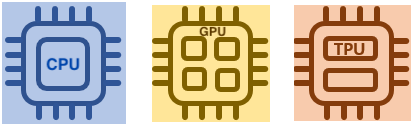


In [ ]:
# TPU
#config_1 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 32, batch_size = 32, epochs = 2, train_splits = 2, accelerator = "TPU")
#preds_train_1, preds_test_1 = run_model(config_1)

# GPU
#config_2 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 32, batch_size = 32, epochs = 2, train_splits = 2, accelerator = "GPU")
#preds_train_2, preds_test_2 = run_model(config_2)

# CPU
#config_3 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 32, batch_size = 32, epochs = 2, train_splits = 2, accelerator = "CPU")
#preds_train_3, preds_test_3 = run_model(config_3)


## Final model
After experimenting with various hyperparameters and finalizing the best combination, we run the those configuration(s).


In [ ]:
# Final Model: XLM Roberta Large
config = Configuration("jplu/tf-xlm-roberta-large", translation = False, max_length = 84, batch_size = 64, epochs = 16, train_splits = 4)
preds_train, preds_test = run_model(config)

## TEST RESULTS
Creating the test result file by predicting the label with highest probability.


In [ ]:
df_test = pd.read_csv(config.PATH_TEST)

df_result = pd.DataFrame({"premise": df_test.premise.values, "hypothesis": df_test.hypothesis.values, "prediction": np.argmax(preds_test, axis = 1)})
print(df_result)
df_result.prediction.value_counts()
df_result.to_csv("result.csv", index = False)